<h1>폐렴 진단기 성능개선</h1>

폐렴 사진 데이터를 학습시켜 정상인 폐의 사진과 폐렴이 있는 사진을 분류

<h3>프로젝트 목표</h3>
<br>
Step 1. 실험환경 Set-up<br>
Step 2. 데이터 준비하기<br>
Step 3. 데이터 시각화<br>
Step 4. ResNet-18구현<br>
Step 5. 데이터 imbalance 처리<br>
Step 6. 모델 훈련<br>
Step 7. 결과 확인과 시각화

<h2> Step 1. 실험환경 Set-up(Batch size, Epoch 설정)</h2>

In [2]:
import re
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import random

In [3]:
#데이터 로드할 때 빠르게 로드할 수 있도록 하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
ROOT_PATH = os.path.join(os.getenv('HOME'),'aiffel')

BATCH_SIZE = 16
IMAGE_SIZE = [180,180]
EPOCHS = 5

print(ROOT_PATH)

#데이터 경로 변수

/aiffel/aiffel


<h2>Step 2. 데이터 준비하기</h2>

In [4]:
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

print(TRAIN_PATH)
print(VAL_PATH)
print(TEST_PATH)

/aiffel/aiffel/chest_xray/data/train/*/*
/aiffel/aiffel/chest_xray/data/val/*/*
/aiffel/aiffel/chest_xray/data/test/*/*


In [5]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와야합니다<br>
때문에 train과 val을 합쳐준 후, 8:2로 나누겠습니다

In [6]:
#train 데이터와 validation 데이터를 모두 filenames에 담는다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

#모아진 filename을 8:2로 나눔
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


정상 폐와 폐렴의 수를 확인해볼까요?

In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if 'NORMAL' in filename])
print('Normal images count in training set : ', str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if 'PNEUMONIA' in filename])
print('Pneumonia image count in training set : ', str(COUNT_PNEUMONIA))

Normal images count in training set :  1070
Pneumonia image count in training set :  3115


폐렴폐가 지나치게 많은 것으로 보여 데이터 불균형이 나타나는 것을 알 수 있습니다<br>
이는 이후에 조정하고 먼저 tf.data 인스턴스를 만들어보겠습니다

In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
#from_tensor_slice()함수는 주어진 텐서로부터 데이터셋을 생성[2]

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print('Training images count:', str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print('Validating images count:', str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


데이터 객수를 확인하여 tf.data인스턴스가 잘 생성되었음을 확인!

In [10]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 데이터가 제각각일 가능성이 높기 때문에 이를 통일 시키고 사이즈를 줄여봅시다<br>
decode_img함수와 process_path함수를 만들어보겠습니다

Process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다<br>
get_label을 이용해서 라벨 값을 가져옵니다

In [11]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어갔는지 확인해볼까요?

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [14]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH+'/chest_xray/data/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # buffersize는 유지하되 그 안에서 shuffle
    ds = ds.repeat() # epoch에 맞게 필요한 만큼 데이터를 반복해서 수를 맞춰줍니다.
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE) 
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

<h2>Step 3. 데이터 시각화</h2>

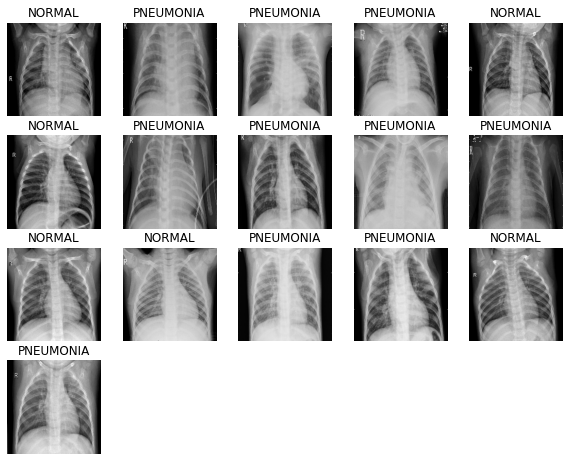

In [16]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(16):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NORMAL')
        plt.axis('off')

show_batch(image_batch.numpy(), label_batch.numpy())

In [17]:
print(image_batch.shape)

(16, 180, 180, 3)


<h2>Step04. ResNet-18구현</h2>

In [18]:
def conv_block(x, filters, strides=1):
    x = tf.keras.layers.Conv2D(filters, 3, strides=strides, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [19]:
def identity_block(tensor, filters):
    x = conv_block(tensor, filters)
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Skip connection
    x = tf.keras.layers.Add()([x, tensor])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [20]:
def identity_block(tensor, filters):
    x = conv_block(tensor, filters)  # conv_block() 함수를 사용하여 컨볼루션 레이어 생성
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Skip connection
    x = tf.keras.layers.Add()([x, tensor])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def residual_block(x, filters, strides=1):
    shortcut = x
    x = conv_block(x, filters, strides)  # conv_block() 함수를 사용하여 컨볼루션 레이어 생성
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Adjusting the dimensions of the shortcut to fit the residual
    if strides != 1:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=strides, padding='same')(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    # Skip connection
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [21]:
def build_resnet():
    inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    x = residual_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)

    x = residual_block(x, 128, strides=2)
    x = identity_block(x, 128)
    x = identity_block(x, 128)

    x = residual_block(x, 256, strides=2)
    x = identity_block(x, 256)
    x = identity_block(x, 256)

    x = residual_block(x, 512, strides=2)
    x = identity_block(x, 512)
    x = identity_block(x, 512)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

<h2>Step5. 데이터 imbalance 처리</h2>

불균형 데이터란 정상 범주의 관측치 수와 이상범주의 관측치 수가 현저히 차이나는 데이터를 말합니다.
예를 들면, 암 발생 환자가 암에 걸리지 않은 사람보다 현저히 적고, 신용카드 사기 거래인 경우가 정상 거래인 경우보다 현저히 적습니다.

<h4>문제점</h4>
정상을 정확히 분류하는 것과 이상을 정확히 분류하는 것 중 일반적으로 이상을 정확히 분류하는 것이 더 중요합니다. 왜냐하면 보통 이상 데이터가 taget값이 되는 경우가 많기 때문입니다.[3]

In [22]:
weight_for_0 = (1/COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1/COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0:weight_for_0, 1:weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.96
Weight for class 1: 0.67


<h2>Step6. 모델 훈련</h2>

In [23]:
with tf.device('/GPU:0'):
    model = build_resnet()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS)

In [24]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/5
261/261 [==============================] - 67s 204ms/step - loss: 0.3034 - accuracy: 0.8803 - precision: 0.9572 - recall: 0.8784 - val_loss: 2.5593 - val_accuracy: 0.3942 - val_precision: 0.9925 - val_recall: 0.1745
Epoch 2/5
261/261 [==============================] - 53s 202ms/step - loss: 0.1785 - accuracy: 0.9361 - precision: 0.9813 - recall: 0.9317 - val_loss: 0.1576 - val_accuracy: 0.9356 - val_precision: 0.9640 - val_recall: 0.9476
Epoch 3/5
261/261 [==============================] - 53s 203ms/step - loss: 0.1554 - accuracy: 0.9394 - precision: 0.9792 - recall: 0.9385 - val_loss: 19.7692 - val_accuracy: 0.2683 - val_precision: 1.0000 - val_recall: 0.0026
Epoch 4/5
261/261 [==============================] - 54s 209ms/step - loss: 0.1200 - accuracy: 0.9569 - precision: 0.9874 - recall: 0.9544 - val_loss: 0.4875 - val_accuracy: 0.7740 - val_precision: 0.9907 - val_recall: 0.6982
Epoch 5/5
261/261 [==============================] - 55s 212ms/step - loss: 0.1012 - accuracy: 

<h2>Step7. 결과 확인과 시각화</h2>

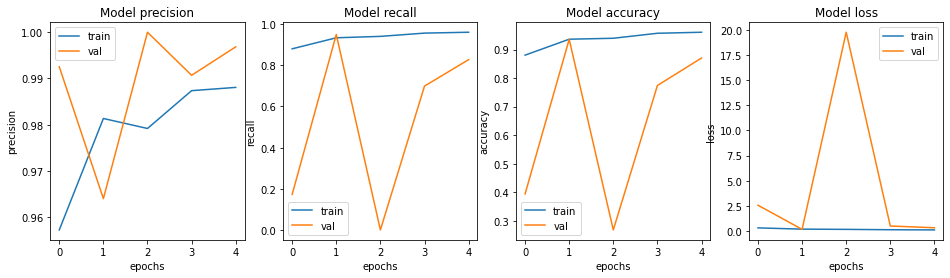

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_'+met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [26]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 5s 126ms/step - loss: 0.4444 - accuracy: 0.8365 - precision: 0.8349 - recall: 0.9205


성능이 적은 것을 보아 좀더 개선을 해볼 필요가 있다고 생각한다

<h2>성능 개선</h2>

<h3>data augmentation 추가</h3>

데이터가 많아진다는 것은 overfitting을 줄일 수 있다는 것을 의미합니다.<br>
갖고 있는 데이터셋이 실제 상황에서의 입력값과 다를 경우, augmentation을 통해 실제 입력값과 비슷한 데이터 분포를 만들 수 있습니다.<br>
<br>
예를 들어, 학습한 데이터는 노이즈가 많이 없는 사진이지만 테스트 이미지는 다양한 노이즈가 있는 경우 테스트에서 좋은 성능을 내기 위해서는 노이즈의 분포를 예측하고 학습 데이터에 노이즈를 삽입하여 모델이 노이즈에 잘 대응할 수 있도록 해야 합니다.[4]

In [52]:
def preprocess_image(image, label):
    desired_height = 180
    desired_width = 180
    
    # 이미지 크기를 원하는 크기로 조정합니다.
    image = tf.image.resize(image, (desired_height, desired_width))
    return image, label

# 데이터셋을 처리하여 이미지의 차원을 변경합니다.
train_ds_4d = train_ds.map(preprocess_image)
val_ds_4d = val_ds.map(preprocess_image)

def augment(image, label):
    image = tf.image.random_flip_left_right(image) # 랜덤 좌우반전
    image, label = preprocess_image(image, label) # 이미지 크기 조정
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_t = prepare_for_training(train_ds)
val_ds_t = prepare_for_training(val_ds)

print(train_ds_4d)

<MapDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>


In [31]:
# train_ds에서 이미지를 가져옵니다.
for images, labels in train_ds.take(1):  # 1 배치만 가져오는 예시입니다.
    print(images.shape)  # 이미지의 형태를 출력합니다.

(16, 180, 180, 3)


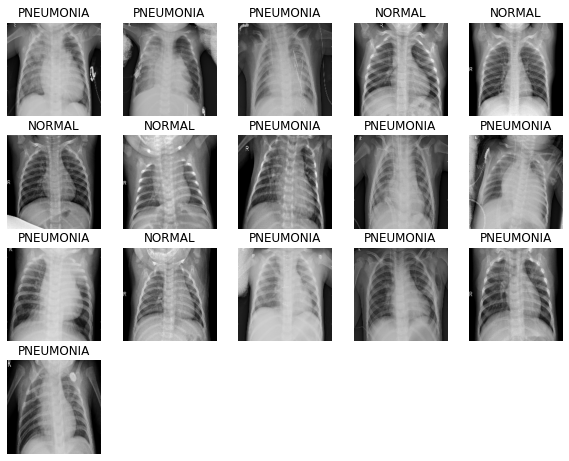

In [28]:
show_batch(image_batch.numpy(), label_batch.numpy())

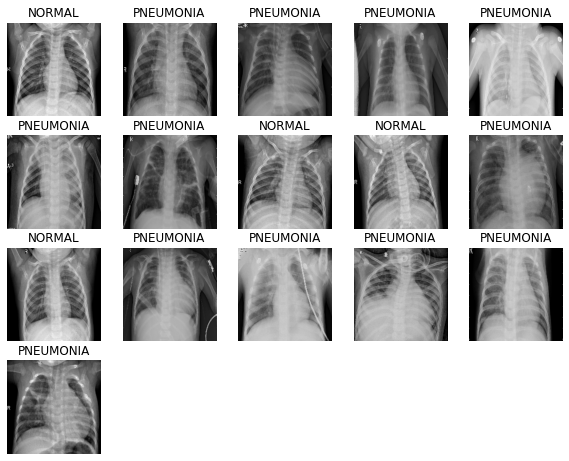

In [41]:
image_batch, label_batch = next(iter(train_ds_4d))
show_batch(image_batch.numpy(), label_batch.numpy())

In [44]:
def conv_block(x, filters, strides=1):
    x = tf.keras.layers.Conv2D(filters, 3, strides=strides, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [45]:
def identity_block(tensor, filters):
    x = conv_block(tensor, filters)
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Skip connection
    x = tf.keras.layers.Add()([x, tensor])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [46]:
def identity_block(tensor, filters):
    x = conv_block(tensor, filters)  # conv_block() 함수를 사용하여 컨볼루션 레이어 생성
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Skip connection
    x = tf.keras.layers.Add()([x, tensor])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def residual_block(x, filters, strides=1):
    shortcut = x
    x = conv_block(x, filters, strides)  # conv_block() 함수를 사용하여 컨볼루션 레이어 생성
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Adjusting the dimensions of the shortcut to fit the residual
    if strides != 1:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=strides, padding='same')(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    # Skip connection
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [47]:
def build_resnet():
    inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    x = residual_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)

    x = residual_block(x, 128, strides=2)
    x = identity_block(x, 128)
    x = identity_block(x, 128)

    x = residual_block(x, 256, strides=2)
    x = identity_block(x, 256)
    x = identity_block(x, 256)

    x = residual_block(x, 512, strides=2)
    x = identity_block(x, 512)
    x = identity_block(x, 512)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [49]:
with tf.device('/GPU:0'):
    model = build_resnet()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS)

In [53]:
EPOCHS = 30

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_4d,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_4d,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
261/261 [==============================] - 64s 204ms/step - loss: 0.3504 - accuracy: 0.8688 - precision: 0.9565 - recall: 0.8629 - val_loss: 1.2644 - val_accuracy: 0.7606 - val_precision: 0.7549 - val_recall: 0.9987
Epoch 2/30
261/261 [==============================] - 52s 200ms/step - loss: 0.1959 - accuracy: 0.9239 - precision: 0.9735 - recall: 0.9228 - val_loss: 0.1859 - val_accuracy: 0.9327 - val_precision: 0.9676 - val_recall: 0.9397
Epoch 3/30
261/261 [==============================] - 52s 200ms/step - loss: 0.1495 - accuracy: 0.9425 - precision: 0.9822 - recall: 0.9399 - val_loss: 3.8720 - val_accuracy: 0.3202 - val_precision: 1.0000 - val_recall: 0.0710
Epoch 4/30
261/261 [==============================] - 53s 202ms/step - loss: 0.1150 - accuracy: 0.9552 - precision: 0.9847 - recall: 0.9546 - val_loss: 0.1498 - val_accuracy: 0.9433 - val_precision: 0.9757 - val_recall: 0.9463
Epoch 5/30
261/261 [==============================] - 54s 206ms/step - loss: 0.1070 - accura

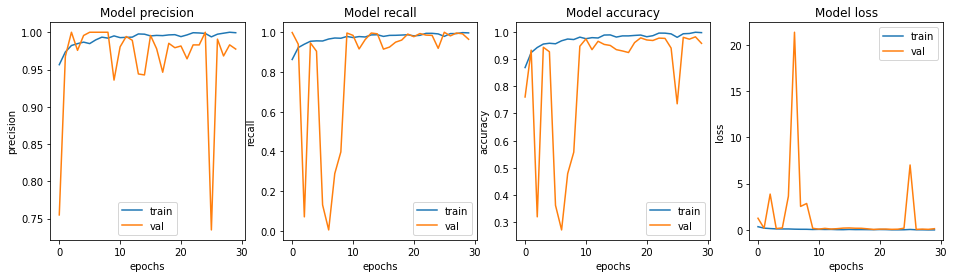

In [54]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_'+met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [55]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 5s 121ms/step - loss: 1.1092 - accuracy: 0.8221 - precision: 0.7888 - recall: 0.9769


아래와 비교해보았을 때 precision과 recall이 증가한 것을 볼 수 있다

39/39 [==============================] - 5s 126ms/step - loss: 0.4444 - accuracy: 0.8365 - precision: 0.8349 - recall: 0.9205

<h2>다양한 최적화 기법 사용</h2>

In [60]:
with tf.device('/GPU:0'):
    model = build_resnet()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.compile(
    optimizer= optimizer,
    loss='binary_crossentropy',
    metrics='accuracy')

In [61]:
EPOCHS = 30

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_4d,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_4d,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
261/261 [==============================] - 61s 196ms/step - loss: 0.3824 - accuracy: 0.8621 - val_loss: 0.9376 - val_accuracy: 0.6779
Epoch 2/30
261/261 [==============================] - 51s 196ms/step - loss: 0.1507 - accuracy: 0.9404 - val_loss: 0.1040 - val_accuracy: 0.9644
Epoch 3/30
261/261 [==============================] - 51s 195ms/step - loss: 0.0912 - accuracy: 0.9662 - val_loss: 0.2309 - val_accuracy: 0.8981
Epoch 4/30
261/261 [==============================] - 51s 196ms/step - loss: 0.0986 - accuracy: 0.9595 - val_loss: 0.0997 - val_accuracy: 0.9654
Epoch 5/30
261/261 [==============================] - 52s 200ms/step - loss: 0.0556 - accuracy: 0.9782 - val_loss: 0.1357 - val_accuracy: 0.9413
Epoch 6/30
261/261 [==============================] - 53s 204ms/step - loss: 0.0567 - accuracy: 0.9782 - val_loss: 1.1708 - val_accuracy: 0.7519
Epoch 7/30
261/261 [==============================] - 56s 216ms/step - loss: 0.0349 - accuracy: 0.9864 - val_loss: 0.1464 - val_ac

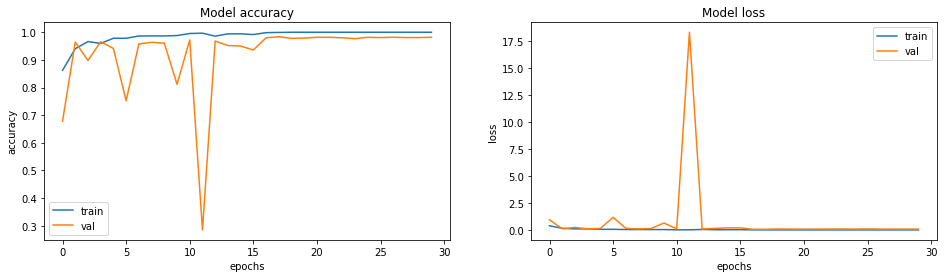

In [68]:
# 시각화 코드
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_'+met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.show()

In [69]:
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f'최종 훈련 정확도: {final_train_accuracy:.4f}')
print(f'최종 검증 정확도: {final_val_accuracy:.4f}')

최종 훈련 정확도: 1.0000
최종 검증 정확도: 0.9817


<h2>회고</h2>

<h3>어려웠던 점</h3><br>
데이터 증강을 시도하던 중 갑자기 이미지 shape가 5차원으로 변경되어 이를 다시 resize하기 위해 이것저것 시도하다가 시간이 많이 흘러갔습니다. 결국 마지막에 직접 숫자를 입력하여 resize를 진행하였습니다. 그리고 증강 데이터를 보았을 때 이것이 제대로 증강이 된 것이 맞는지 확인하는것이 어려웠습니다.<br>
<br>
<h3>새로 배운 점</h3><br>
data argumentation을 진행해보고 진행사항을 그래프로 보았을 때 훨씬 안정화되어있는 것을 확인할 수 있었습니다. 이에 대한 자세한 내용들을 인터넷을 통해 많이 알아보면서 함수쪽도 많이 공부할 수 있었습니다. 그리고 제일 마지막에 optimizer를 바꾼것만으로도 정확도가 훨씬 올라가는 것을 보아 하이퍼파라미터를 최적화하는 것에 대한 중요성도 알았습니다.<br>
<br>
<h3>앞으로의 계획</h3><br>
정확도가 생각보다 더 높게 나오지는 않아서 이에 대한 방법을 좀더 찾아보아야한다고 생각합니다. 앞으로 배우는 노드에서나 인터넷에서 다른 방법을 발견하게 된다면 한번 시도해볼 예정입니다.


<h3>reference</h3>
<br>


[1]list append()와 extend()의 차이점 : https://blog.naver.com/PostView.naverblogId=wideeyed&logNo=221541104629<br>
[2] tf.data: TensorFlow 입력 파이프라인 빌드<br>
https://www.tensorflow.org/guide/data?hl=ko<br>
[3] 불균형 데이터(imbalanced data)처리를 위한 샘플링 기법<br>
https://casa-de-feel.tistory.com/15<br>
[4]Data augmentation란? 데이터 증강 방법과 예시<br>
https://velog.io/@cha-suyeon/Data-augmentation
